In [2]:
import datetime
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import os

from sklearn.model_selection import train_test_split
# from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array 

import zipfile

%load_ext tensorboard

# Import the data

In [3]:

# Train -> original given data
# data_dir = '/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/data/Train'

# Train_augumented_dataset
# data_dir = '/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/data/Train_augumented_dataset'

# Train_cleaned_dataset
# data_dir = '/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/data/Train_cleaned_dataset'

# Train_cleaned_and_augumented
data_dir = '/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/data/Train_cleaned_and_augumented'

batch_size = 32
img_height = 256
img_width = 256

# Split dataset

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # voor de trainset neemt tf 80% mee.
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  # voor de validation set neemt tf 20% mee.
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

class_names = train_ds.class_names
print(class_names)

Found 2952 files belonging to 4 classes.
Using 2362 files for training.


2022-11-03 22:11:40.295827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2952 files belonging to 4 classes.
Using 590 files for validation.
['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


(32, 180, 180, 3)
(32,)


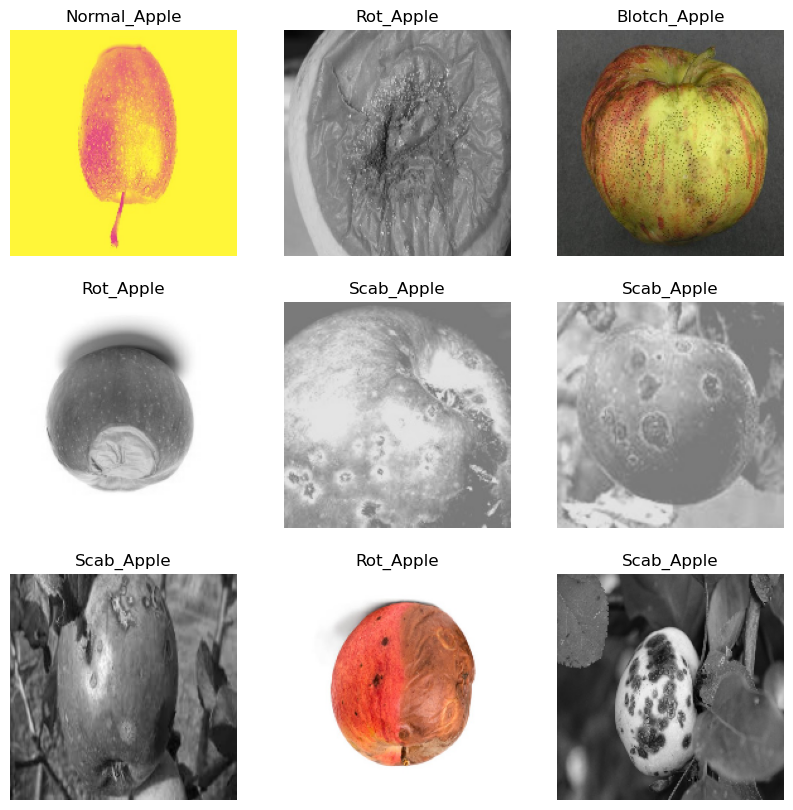

In [5]:
#PLOT IMAGES FROM TRAINSET
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


# Building the model

In [6]:
# model = Sequential()
# num_classes = len(class_names)

# model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
# model.add(layers.Conv2D(128, 3, activation='relu'))
  
# model.add(layers.MaxPooling2D())
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(128, 3, activation='relu'))

# model.add(layers.MaxPooling2D())
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(128, 3, activation='relu'))
  
# model.add(layers.MaxPooling2D())
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))

# model.summary()

In [7]:
# Model form paper

model = Sequential()
num_classes = len(class_names)

model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2592))
model.add(layers.Dense(256))

model.add(layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 3)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 128)       3584      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

In [8]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 3)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 128)       3584      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

# TRAINING THE MODEL

In [9]:
logdir = '/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/logs' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train_ds, epochs = 30, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/30
74/74 [==============================] - 105s 1s/step - loss: 1.3342 - accuracy: 0.3616 - val_loss: 1.2657 - val_accuracy: 0.4678
Epoch 2/30
74/74 [==============================] - 83s 1s/step - loss: 1.2033 - accuracy: 0.4543 - val_loss: 1.1395 - val_accuracy: 0.4763
Epoch 3/30
74/74 [==============================] - 79s 1s/step - loss: 1.1183 - accuracy: 0.5250 - val_loss: 1.0310 - val_accuracy: 0.5729
Epoch 4/30
74/74 [==============================] - 79s 1s/step - loss: 0.9564 - accuracy: 0.6207 - val_loss: 0.9491 - val_accuracy: 0.6220
Epoch 5/30
74/74 [==============================] - 77s 1s/step - loss: 0.7951 - accuracy: 0.6909 - val_loss: 0.8714 - val_accuracy: 0.6525
Epoch 6/30
74/74 [==============================] - 76s 1s/step - loss: 0.6730 - accuracy: 0.7413 - val_loss: 0.7232 - val_accuracy: 0.7153
Epoch 7/30
74/74 [==============================] - 73s 985ms/step - loss: 0.5885 - accuracy: 0.7693 - val_loss: 0.5848 - val_accuracy: 0.7763
Epoch 8/30
74/74

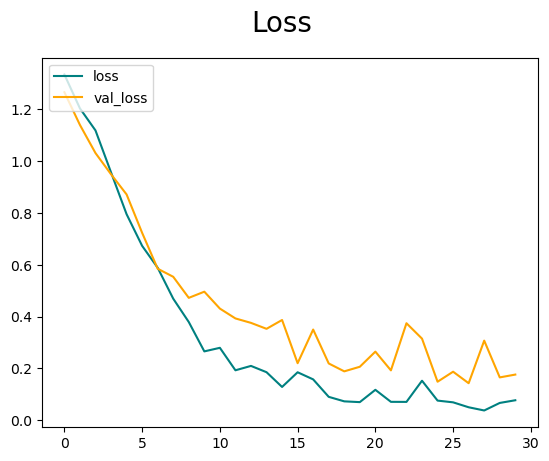

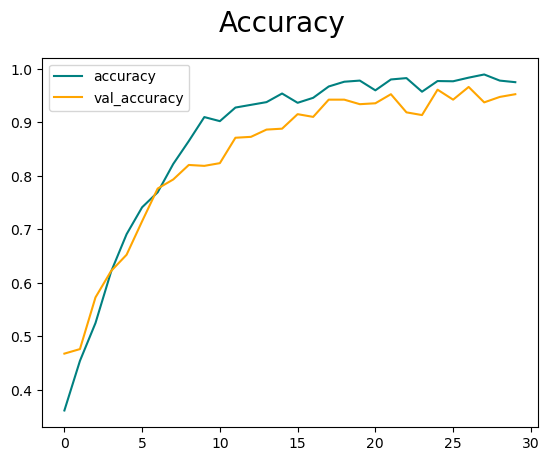

In [10]:
# PLOT OF LOSS
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# PLOT OF ACCUARCY
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [11]:
model.save(os.path.join('models','cleanedAndAugumented.h5'))

In [12]:
# new_model = load_model('cleanedAndAugumented.h5')

In [13]:
# new_model.predict(np.expand_dims(resize/255, 0))

# Prediction

This image most likely belongs to Blotch_Apple with a 100.00 percent confidence. 



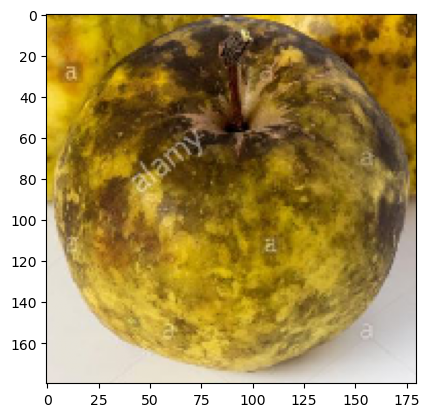

In [14]:
openImage1 = load_img('/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/data/Test/Blotch_Apple/121.jpg',target_size=(180, 180))
                 
# model = r'./EXAMPLE'
# model = tf.keras.models.load_model(cnn_trained) # inladen trainingsmodel via keras.

def makePrediction(openImage): 
    
    img = np.asarray(openImage).astype('uint8')/255 # normaliseren van de foto.
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    # model = tf.keras.models.load_model(cnn_trained) # inladen trainingsmodel via keras
    
    prediction = model.predict(img_array)
    score = tf.nn.softmax(prediction[0])
    print('This image most likely belongs to {} with a {:.2f} percent confidence.'
         .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n'
         )
    plt.imshow(img)
    
makePrediction(openImage1)

# Confusion matrix

Found 120 files belonging to 4 classes.
['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


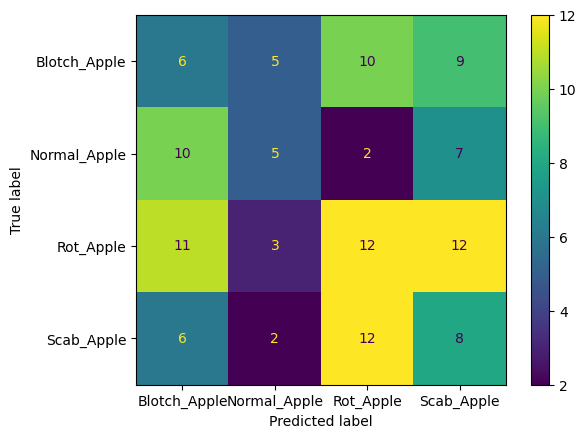

In [15]:

test_data_dir = '/Users/boyfrankclaesen/workspace/makeAIWork2/projects/apple_disease_classification/imageClassifier/data/Test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_label = test_ds.class_names
print(test_label)

# PLOT CONFUSION MATRIX
batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple'])

cm_display.plot()

plt.show()